In [7]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# # Step 1: Load the image
# image = Image.open("Discc/4.jpg")
# image_array = np.array(image)
# height, width, _ = image_array.shape

# # Step 2: Define zoomed ROI (50% zoom-in region)
# roi_scale = 0.5
# roi_width = int(width * roi_scale)
# roi_height = int(height * roi_scale)
# x_offset = (roi_width - width) // 2
# y_offset = (roi_height - height) // 2

# # Ensure ROI doesn't exceed image bounds
# x_start = max(0, -x_offset)
# x_end = min(width, width + x_offset)
# y_start = max(0, -y_offset)
# y_end = min(height, height + y_offset)
# roi = image_array[y_start:y_end, x_start:x_end]

# # Step 3: Convert to HSV-like values manually
# def rgb_to_hsv_manual(image):
#     """
#     Convert an RGB image to HSV manually.
#     Returns separate hue, saturation, and value arrays.
#     """
#     # Normalize RGB values to [0, 1]
#     image = image / 255.0
#     r, g, b = image[..., 0], image[..., 1], image[..., 2]
#     cmax = np.max(image, axis=-1)
#     cmin = np.min(image, axis=-1)
#     delta = cmax - cmin

#     # Calculate Hue
#     hue = np.zeros_like(cmax)
#     mask = delta > 0
#     hue[mask & (cmax == r)] = ((g - b) / delta % 6)[mask & (cmax == r)]
#     hue[mask & (cmax == g)] = ((b - r) / delta + 2)[mask & (cmax == g)]
#     hue[mask & (cmax == b)] = ((r - g) / delta + 4)[mask & (cmax == b)]
#     hue = hue / 6  # Scale hue to [0, 1]

#     # Calculate Saturation
#     saturation = np.zeros_like(cmax)
#     saturation[cmax > 0] = delta[cmax > 0] / cmax[cmax > 0]

#     # Value (Brightness)
#     value = cmax

#     return hue, saturation, value

# # Convert ROI to HSV
# hue, saturation, value = rgb_to_hsv_manual(roi)

# # Step 4: Normalize Brightness (Histogram Equalization)
# def normalize_brightness(value_channel):
#     """
#     Normalize brightness (Value) using simple linear scaling.
#     Scales the Value channel to [0, 1].
#     """
#     value_min = np.min(value_channel)
#     value_max = np.max(value_channel)
#     if value_max > value_min:
#         normalized_value = (value_channel - value_min) / (value_max - value_min)
#     else:
#         normalized_value = value_channel  # If uniform brightness
#     return normalized_value

# value = normalize_brightness(value)

# # Step 5: Adjust HSV thresholds dynamically
# def adjust_thresholds_dynamically(value_channel):
#     """
#     Dynamically adjust HSV thresholds based on brightness.
#     Returns updated hue, saturation, and value thresholds.
#     """
#     avg_brightness = np.mean(value_channel)  # Calculate average brightness
#     if avg_brightness < 0.3:  # Dim images
#         return 0.10, 0.25, 0.1, 0.9, 0.1, 0.99  # Relaxed thresholds
#     elif avg_brightness > 0.7:  # Bright images
#         return 0.10, 0.20, 0.1, 0.9, 0.2, 0.9  # Tighter thresholds
#     else:  # Normal images
#         return 0.10, 0.20, 0.1, 0.9, 0.2, 0.9  # Default thresholds

# lower_hue, upper_hue, lower_saturation, upper_saturation, lower_value, upper_value = adjust_thresholds_dynamically(value)

# # Step 6: Create the mask for sand-brown shades
# # The thresholds below can be further adjusted to fine-tune the detection
# mask = (
#     (hue >= lower_hue) & (hue <= upper_hue) &  # Hue range
#     (saturation >= lower_saturation) & (saturation <= upper_saturation) &  # Saturation range
#     (value >= lower_value) & (value <= upper_value)  # Brightness range
# )

# # Step 7: Refine the mask
# def refine_mask(mask):
#     """
#     Refine the binary mask using simple operations:
#     - Closing gaps in the mask
#     - Expanding detected regions
#     """
#     refined_mask = np.copy(mask)
#     for _ in range(2):  # Perform 2 passes to close small gaps
#         # Check neighbors to fill holes
#         for i in range(1, mask.shape[0] - 1):
#             for j in range(1, mask.shape[1] - 1):
#                 if not refined_mask[i, j]:
#                     neighbors = mask[i-1:i+2, j-1:j+2]
#                     if np.sum(neighbors) >= 5:  # Fill if 5+ neighbors are True
#                         refined_mask[i, j] = True
#     return refined_mask

# refined_mask = refine_mask(mask)

# # Step 8: Blob detection (largest connected region)
# def find_largest_blob(binary_mask):
#     """
#     Find the largest connected blob in a binary mask.
#     Returns the coordinates of the largest blob and its area.
#     """
#     visited = np.zeros_like(binary_mask, dtype=bool)
#     max_area = 0
#     largest_blob_coords = []

#     def dfs(x, y):
#         stack = [(x, y)]
#         blob_coords = []
#         while stack:
#             cx, cy = stack.pop()
#             if not visited[cx, cy] and binary_mask[cx, cy]:
#                 visited[cx, cy] = True
#                 blob_coords.append((cx, cy))
#                 # Add neighbors
#                 for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
#                     nx, ny = cx + dx, cy + dy
#                     if 0 <= nx < binary_mask.shape[0] and 0 <= ny < binary_mask.shape[1]:
#                         stack.append((nx, ny))
#         return blob_coords

#     for i in range(binary_mask.shape[0]):
#         for j in range(binary_mask.shape[1]):
#             if binary_mask[i, j] and not visited[i, j]:
#                 blob = dfs(i, j)
#                 if len(blob) > max_area:
#                     max_area = len(blob)
#                     largest_blob_coords = blob

#     return largest_blob_coords, max_area

# largest_blob, blob_area = find_largest_blob(refined_mask)
# brown_pixel_count = np.sum(refined_mask)

# # Step 9: Disc detection based on brown-pixel density
# brown_pixel_threshold = 0.05  # Proportion of brown pixels in the mask
# total_pixels = refined_mask.shape[0] * refined_mask.shape[1]
# brown_pixel_density = brown_pixel_count / total_pixels

# is_disc_present = brown_pixel_density > brown_pixel_threshold and blob_area > 0.05 * total_pixels

# # Draw bounding box around largest blob if disc is present
# if is_disc_present and largest_blob:
#     largest_blob = np.array(largest_blob)
#     min_y, min_x = np.min(largest_blob, axis=0)
#     max_y, max_x = np.max(largest_blob, axis=0)

#     # Draw bounding box on ROI
#     roi[min_y:max_y, min_x] = [0, 255, 0]  # Vertical line
#     roi[min_y:max_y, max_x] = [0, 255, 0]
#     roi[min_y, min_x:max_x] = [0, 255, 0]  # Horizontal line
#     roi[max_y, min_x:max_x] = [0, 255, 0]

#     print(f"Disc detected! Bounding box: Top-left ({min_x}, {min_y}), Bottom-right ({max_x}, {max_y})")
# else:
#     print("No disc detected.")

# # Visualization using Matplotlib
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Original Image
# axes[0].imshow(image)
# axes[0].set_title("Original Image")
# axes[0].axis("off")

# # Zoomed ROI with detected disc
# axes[1].imshow(roi)
# axes[1].set_title("Zoomed ROI with Detected Disc")
# axes[1].axis("off")

# # Mask of Sand Brown
# axes[2].imshow(refined_mask, cmap="gray")
# axes[2].set_title("Sand Brown Mask")
# axes[2].axis("off")

# plt.tight_layout()
# plt.show()


/tmp/ipykernel_92893/1617736963.py:33: RuntimeWarning: invalid value encountered in divide
  hue[mask & (cmax == r)] = ((g - b) / delta % 6)[mask & (cmax == r)]
/tmp/ipykernel_92893/1617736963.py:34: RuntimeWarning: invalid value encountered in divide
  hue[mask & (cmax == g)] = ((b - r) / delta + 2)[mask & (cmax == g)]
/tmp/ipykernel_92893/1617736963.py:35: RuntimeWarning: invalid value encountered in divide
  hue[mask & (cmax == b)] = ((r - g) / delta + 4)[mask & (cmax == b)]


Hue range: Min=0.00, Max=0.96, Mean=0.42
Saturation range: Min=0.00, Max=0.74, Mean=0.14
Value range: Min=0.01, Max=1.00, Mean=0.42
Hue thresholds: 0.12 to 0.22
Saturation thresholds: 0.20 to 0.60
Value thresholds: 0.20 to 0.90
Hue mask coverage: 8501/42000 pixels
Saturation mask coverage: 10028/42000 pixels
Value mask coverage: 28675/42000 pixels


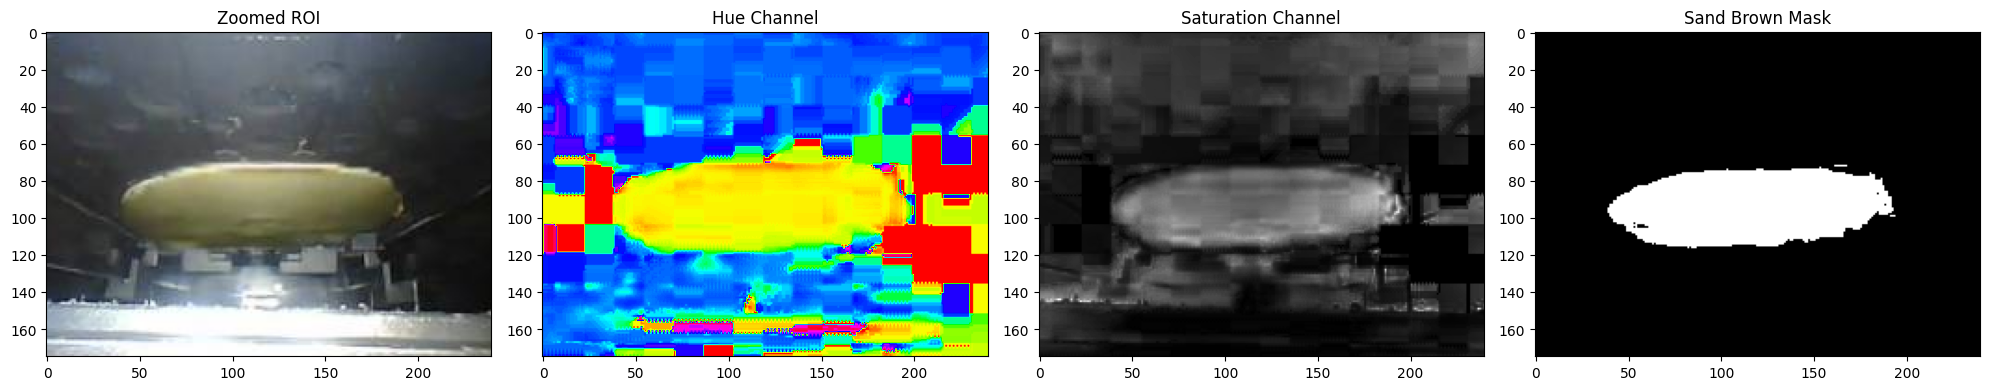

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = Image.open("Discc/4.jpg")
image_array = np.array(image)
height, width, _ = image_array.shape

# Define zoomed ROI (50% zoom-in region)
roi_scale = 0.5
roi_width = int(width * roi_scale)
roi_height = int(height * roi_scale)
x_offset = (roi_width - width) // 2
y_offset = (roi_height - height) // 2

x_start = max(0, -x_offset)
x_end = min(width, width + x_offset)
y_start = max(0, -y_offset)
y_end = min(height, height + y_offset)
roi = image_array[y_start:y_end, x_start:x_end]

# Convert to HSV-like values manually
def rgb_to_hsv_manual(image):
    image = image / 255.0
    r, g, b = image[..., 0], image[..., 1], image[..., 2]
    cmax = np.max(image, axis=-1)
    cmin = np.min(image, axis=-1)
    delta = cmax - cmin

    hue = np.zeros_like(cmax)
    mask = delta > 0
    hue[mask & (cmax == r)] = ((g - b) / delta % 6)[mask & (cmax == r)]
    hue[mask & (cmax == g)] = ((b - r) / delta + 2)[mask & (cmax == g)]
    hue[mask & (cmax == b)] = ((r - g) / delta + 4)[mask & (cmax == b)]
    hue = hue / 6  # Scale hue to [0, 1]

    saturation = np.zeros_like(cmax)
    saturation[cmax > 0] = delta[cmax > 0] / cmax[cmax > 0]

    value = cmax

    return hue, saturation, value

hue, saturation, value = rgb_to_hsv_manual(roi)

# Debug: Print hue, saturation, and value statistics
print(f"Hue range: Min={hue.min():.2f}, Max={hue.max():.2f}, Mean={hue.mean():.2f}")
print(f"Saturation range: Min={saturation.min():.2f}, Max={saturation.max():.2f}, Mean={saturation.mean():.2f}")
print(f"Value range: Min={value.min():.2f}, Max={value.max():.2f}, Mean={value.mean():.2f}")

# Normalize brightness
def normalize_brightness(value_channel):
    value_min = np.min(value_channel)
    value_max = np.max(value_channel)
    if value_max > value_min:
        normalized_value = (value_channel - value_min) / (value_max - value_min)
    else:
        normalized_value = value_channel
    return normalized_value

value = normalize_brightness(value)

# Adjust HSV thresholds dynamically
def adjust_thresholds_dynamically(value_channel):
    avg_brightness = np.mean(value_channel)
    if avg_brightness < 0.3:  # Dim images
        return 0.10, 0.25, 0.1, 0.7, 0.1, 0.9
    elif avg_brightness > 0.7:  # Bright images
        return 0.10, 0.20, 0.2, 0.5, 0.2, 0.8
    else:  # Normal images
        return 0.12, 0.22, 0.2, 0.6, 0.2, 0.9

lower_hue, upper_hue, lower_saturation, upper_saturation, lower_value, upper_value = adjust_thresholds_dynamically(value)

# Debug: Print thresholds
print(f"Hue thresholds: {lower_hue:.2f} to {upper_hue:.2f}")
print(f"Saturation thresholds: {lower_saturation:.2f} to {upper_saturation:.2f}")
print(f"Value thresholds: {lower_value:.2f} to {upper_value:.2f}")

# Apply mask for sand-brown shades
hue_mask = (hue >= lower_hue) & (hue <= upper_hue)
saturation_mask = (saturation >= lower_saturation) & (saturation <= upper_saturation)
value_mask = (value >= lower_value) & (value <= upper_value)

# Debug: Print mask statistics
print(f"Hue mask coverage: {np.sum(hue_mask)}/{hue.size} pixels")
print(f"Saturation mask coverage: {np.sum(saturation_mask)}/{saturation.size} pixels")
print(f"Value mask coverage: {np.sum(value_mask)}/{value.size} pixels")

# Final combined mask
mask = hue_mask & saturation_mask & value_mask

# Debug: Check why mask might be blank
if np.sum(mask) == 0:
    print("The mask is completely blank. Possible reasons:")
    print("- Hue, saturation, or value thresholds are too restrictive.")
    print("- Input image brightness is affecting the thresholds.")

# Visualize masks
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(roi)
axes[0].set_title("Zoomed ROI")

axes[1].imshow(hue, cmap="hsv")
axes[1].set_title("Hue Channel")

axes[2].imshow(saturation, cmap="gray")
axes[2].set_title("Saturation Channel")

axes[3].imshow(mask, cmap="gray")
axes[3].set_title("Sand Brown Mask")

plt.tight_layout()
plt.show()